In [18]:
import sys

sys.path.append('../..')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from partition import EmbeddingsPartition
from projections import SimplexProjection

import numpy as np
import matplotlib.pyplot as plt
from imblearn.datasets import fetch_datasets


ecoli = fetch_datasets()['ecoli']
X = ecoli.data
y = ecoli.target

minor_class = np.min(y)
train_embeddings = X[y == minor_class]
test_embeddings_full = X[y != minor_class]

print(len(test_embeddings_full), len(train_embeddings))

np.random.seed(42)
test_sample_indices = np.random.choice(test_embeddings_full.shape[0], min(200, len(test_embeddings_full)), replace=False)
test_embeddings = test_embeddings_full[test_sample_indices]

max_k = 7
max_t = 7
t_values = range(1, max_t + 1)
k_values = range(1, max_k + 1)

partitioner = EmbeddingsPartition(train_embeddings, dimension=train_embeddings.shape[1])

all_projections = {t: [] for t in t_values}

def filter_simplexes_by_size(simplexes, size):
    return [simplex for simplex in simplexes if len(simplex) == size]

for t in t_values:
    print(f"Building simplexes with max_k={max_k} and t={t}")
    all_simplexes = partitioner.run_method("clique", k=max_k, t=t)
    print(len(all_simplexes))

    for k in k_values:
        print(f"Filtering simplexes to size t={t} for k={k}")
        filtered_simplexes = filter_simplexes_by_size(all_simplexes, k)
        print(len(filtered_simplexes))

        simplex_projection = SimplexProjection(filtered_simplexes)

        projections, _ = simplex_projection.find_closest_projection(test_embeddings)
        if projections[0][0] is None:
            all_projections[t].append([])
            continue

        distances = np.linalg.norm(test_embeddings - projections, axis=1)
        mean_distance = np.mean(distances)
        all_projections[t].append(projections)

        print(f"Mean distance for t={t}, k={k}: {mean_distance}")

35 301
Building simplexes with max_k=7 and t=1
301
Filtering simplexes to size t=1 for k=1
301
Mean distance for t=1, k=1: 1.0989419180261908
Filtering simplexes to size t=1 for k=2
0
Filtering simplexes to size t=1 for k=3
0
Filtering simplexes to size t=1 for k=4
0
Filtering simplexes to size t=1 for k=5
0
Filtering simplexes to size t=1 for k=6
0
Filtering simplexes to size t=1 for k=7
0
Building simplexes with max_k=7 and t=2
532
Filtering simplexes to size t=2 for k=1
301
Mean distance for t=2, k=1: 1.0989419180261908
Filtering simplexes to size t=2 for k=2
231
Mean distance for t=2, k=2: 0.36881324726012454
Filtering simplexes to size t=2 for k=3
0
Filtering simplexes to size t=2 for k=4
0
Filtering simplexes to size t=2 for k=5
0
Filtering simplexes to size t=2 for k=6
0
Filtering simplexes to size t=2 for k=7
0
Building simplexes with max_k=7 and t=3
822
Filtering simplexes to size t=3 for k=1
301
Mean distance for t=3, k=1: 1.0989419180261908
Filtering simplexes to size t=3 fo

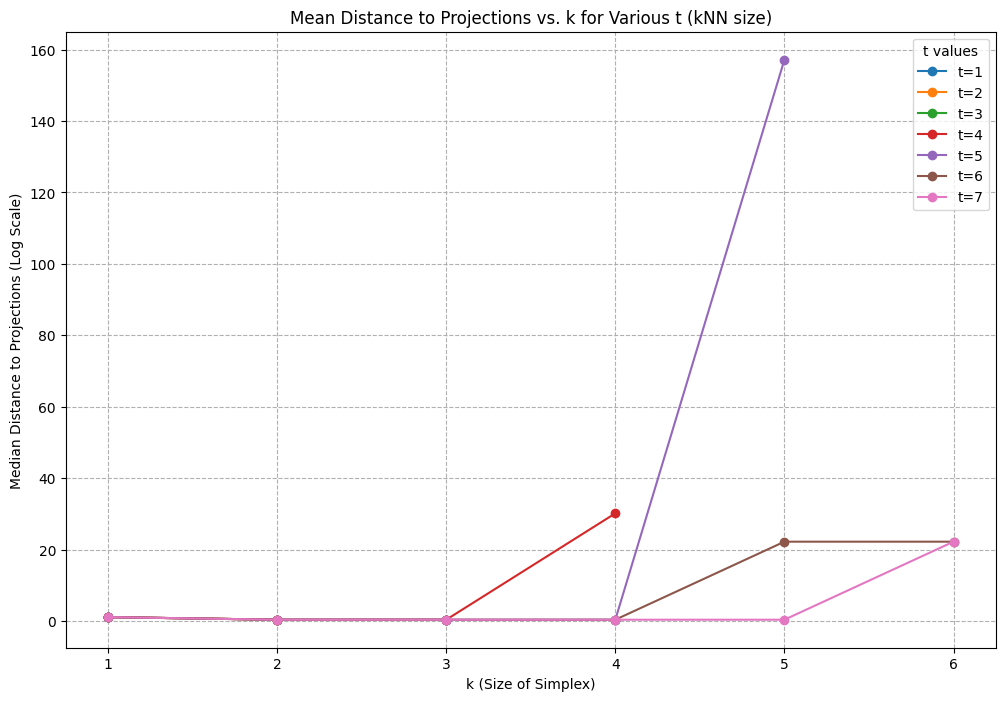

In [48]:
from scipy.optimize import curve_fit

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

median_results = {t: [] for t in t_values}

def calculate_median_distances():
    for t in t_values:
        for idx, k in enumerate(k_values):
            if idx < len(all_projections[t]):
                projection_set = all_projections[t][idx]
                if len(projection_set) > 0:
                    distances = np.linalg.norm(test_embeddings - projection_set, axis=1)
                    median_distance = np.median(distances)
                    median_results[t].append(median_distance)
                else:
                    median_results[t].append(1e9)
            else:
                median_results[t].append(1e9)
                
calculate_median_distances()
                
plt.figure(figsize=(12, 8))
for t in t_values:
    valid_indices = [i for i, val in enumerate(median_results[t]) if val < 1e9]
    valid_k_values = [k_values[i] for i in valid_indices]
    valid_medians = [median_results[t][i] for i in valid_indices]
    plt.plot(valid_k_values, valid_medians, marker='o', linestyle='-', label=f't={t}')
        
plt.title("Mean Distance to Projections vs. k for Various t (kNN size)")
plt.xlabel("k (Size of Simplex)")
plt.ylabel("Median Distance to Projections")
plt.legend(title="t values")
plt.grid(True, which="both", ls="--") 
plt.show()